In [ ]:
import os, sys, random, shutil, warnings


def paint_text(text: str, color : str = 'green') -> str:
    """
    Parameters
    ----------
    text
          text to be colored
    color : default = 'green'
          color to apply on text, one of the following items:
          {black, red, green, yellow, blue, magenta, cyan, white}

    Returns
    -------
    str
    """
    paint_dict = {
    'black': '\033[30m',
    'red': '\033[31m',
    'green': '\033[32m',
    'yellow': '\033[33m',
    'blue': '\033[34m',
    'magenta': '\033[35m',
    'cyan': '\033[36m',
    'white': '\033[37m'
    }
    return paint_dict[color.lower()] + text + '\033[0m'

def init_dataset(api_command: str) -> str:
    """
    Parameters
    ----------
    api_command
                 Kaggle generated API command for dataset. In form of:
                 'kaggle datasets download -d [User ID]/[Dataset Slug]'

    Returns
    -------
    root_address : str
                   Address of the dataset root folder.
    """
    # extract dataset name and user ID based from the API command
    _, dataset_name = api_command.split('/')
    user_id = _.split()[-1]
    print(f'dataset {paint_text(dataset_name):30s}\nuser id {paint_text(user_id):30s}')

    # check if the function is running on Google Colab or Kaggle Kernel
    # if on Google Colab, user must uppload their API key to be able to download
    # the dataset and use it.
    if 'google.colab' in str(get_ipython()):
        # check if API was uploaded previously
        if '.kaggle' not in os.listdir('/root/'):
            from google.colab import files
            files.upload()
            os.system('mkdir ~/.kaggle')
            os.system('mv ./kaggle.json ~/.kaggle/')
            os.system('chmod 600 ~/.kaggle/kaggle.json')
        else:
            if f'{dataset_name}.zip' in os.listdir():
                # in case API key is and dataset file are existed, just a simple
                # warning will be issued
                warnings.warn('Re-downloading the dataset')

        # run the API command and download the dataset
        os.system(f'{api_command}')
        # WARNING: here we assumed the dataset is compressed as a *.zip file.
        # although this is usually true, it might be other types of compression
        # used in some datasets.
        os.system(f'unzip {dataset_name}.zip')

        # in Google Colab, data are stored in local directory
        root_address = '.'
    else:
        # where the data are stored in Kaggle Kernels
        root_address = f'../input/{dataset_name}'
    print(f'data root: {paint_text(root_address, "magenta")}')
    return root_address


In [ ]:
root_address = init_dataset('kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

dataset diabetic-retinopathy-224x224-gaussian-filtered
user id sovitrath            


Saving kaggle.json to kaggle.json
data root: .


In [ ]:
report_dict = {}

In [ ]:
! pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import imagehash
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [ ]:
data_address = f'{root_address}/train.csv'
data = pd.read_csv(data_address)
data.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

<Axes: xlabel='diagnosis', ylabel='count'>

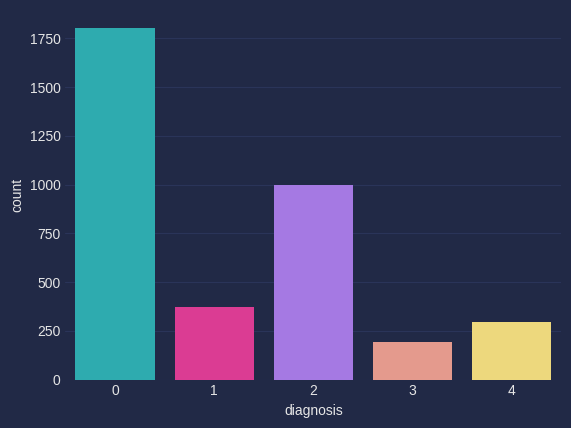

In [ ]:
sns.countplot(
    data=data,
    x='diagnosis'
)

<Axes: xlabel='diagnosis', ylabel='count'>

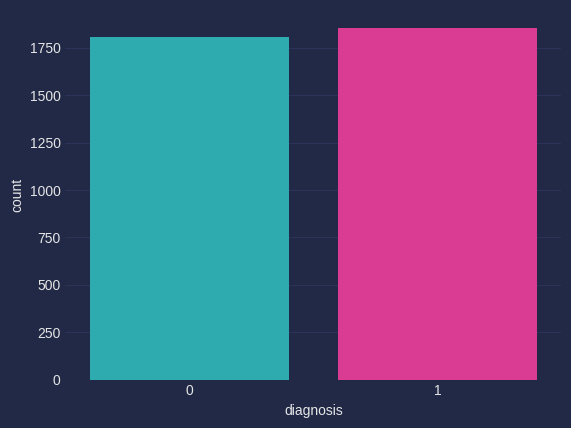

In [ ]:
# copy data
data2 = data.copy()

# select and merge every category other than `No_DR`
data2['diagnosis'] = data2['diagnosis'] > 0
data2['diagnosis'] = data2['diagnosis'].astype('int32')

# plot the distribution of categories
sns.countplot(data=data2, x='diagnosis')

In [ ]:
# test and validation fraction
test_frac, val_frac = 0.25, 0.15

# separate `val` data from the `whole`
_, val = train_test_split(
    data2,
    test_size=val_frac,
    stratify=data2['diagnosis']
)

# separate `test` and `train` from the remaining
train, test = train_test_split(
    _,
    test_size=test_frac/(1-val_frac), # to have the same frac on the `whole`
    stratify=_['diagnosis']
)

# verify
print(f'{train.shape}, {test.shape}, {val.shape}\n')

(2196, 2), (916, 2), (550, 2)



        id_code  diagnosis status
0  000c1434d8d7          1   test
1  001639a390f0          1  train
2  0024cdab0c1e          1   test
3  002c21358ce6          0    val
4  005b95c28852          0  train 



<Axes: xlabel='status', ylabel='Percent'>

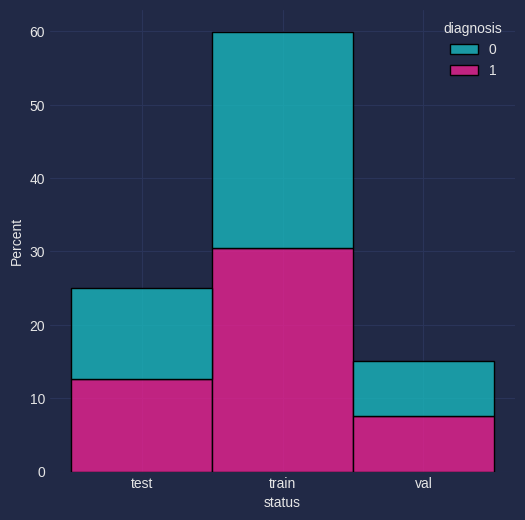

In [ ]:
# Make a new empty columns
data2['status'] = None

# fill values based on the `status`
for name, source in zip(['train', 'test', 'val'], [train, test, val]):
    for j in source.index:
        data2.at[j, 'status'] = name

# check the results
print(data2.head(), '\n')

# plot the distribution
fig = plt.subplots(figsize=(6, 6))

sns.histplot(
    data=data2,
    x='status',
    hue='diagnosis',
    multiple='stack',
    stat='percent'
)

In [ ]:
! mkdir -p data/{train,test,val}/{DR,No_DR}
! mkdir DR

# here we copy all of the images into one folder. Files then will be copied to
# related folders according to `data2`
! mkdir Images
for cat in ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']:
    os.system(f'cp -R {root_address}/gaussian_filtered_images/gaussian_filtered_images/{cat}/* ./Images')

! ls ./Images -1q | wc -l
! echo " files were copied"

3662
 files were copied


In [ ]:


def copy_image(args):
    source, destination = args
    os.system(f'cp {source} {destination}')


# loop over the splits
for name, dataframe in zip(['train', 'test', 'val'], [train, test, val]):
    # Create a list of (source, destination) pairs for image copying
    image_copy_list = []
    for filename, diag_code in zip(dataframe['id_code'], dataframe['diagnosis']):
        source = f'./Images/{filename}.png'
        destination = f'./data/{name}/DR/' if diag_code else f'./data/{name}/No_DR/'
        image_copy_list.append((source, destination))

    with Pool(processes=4) as pool:  # Adjust the number of processes as needed
        pool.map(copy_image, image_copy_list)

    print(f'✅ {name}')






✅ train
✅ test
✅ val


In [ ]:
dup_dict = {}
for split in ['train', 'test', 'val']:
    for im_class in ['DR', 'No_DR']:
        for image_name in os.listdir(f'./data/{split}/{im_class}'):
            image = Image.open(f'./data/{split}/{im_class}/{image_name}')
            image_hash = str(imagehash.phash(image))
            if image_hash not in dup_dict.keys():
                dup_dict[image_hash] = set()
            dup_dict[image_hash].add(f'./data/{split}/{im_class}/{image_name}')

dup_dict2 = {}
num_same = 0
for key in dup_dict:
    if len(dup_dict[key]) > 1:
        dup_dict2[key] = dup_dict[key]
        num_same += len(dup_dict[key])

del dup_dict

print(f'There are {num_same} almost similar images.')

There are 268 almost similar images.


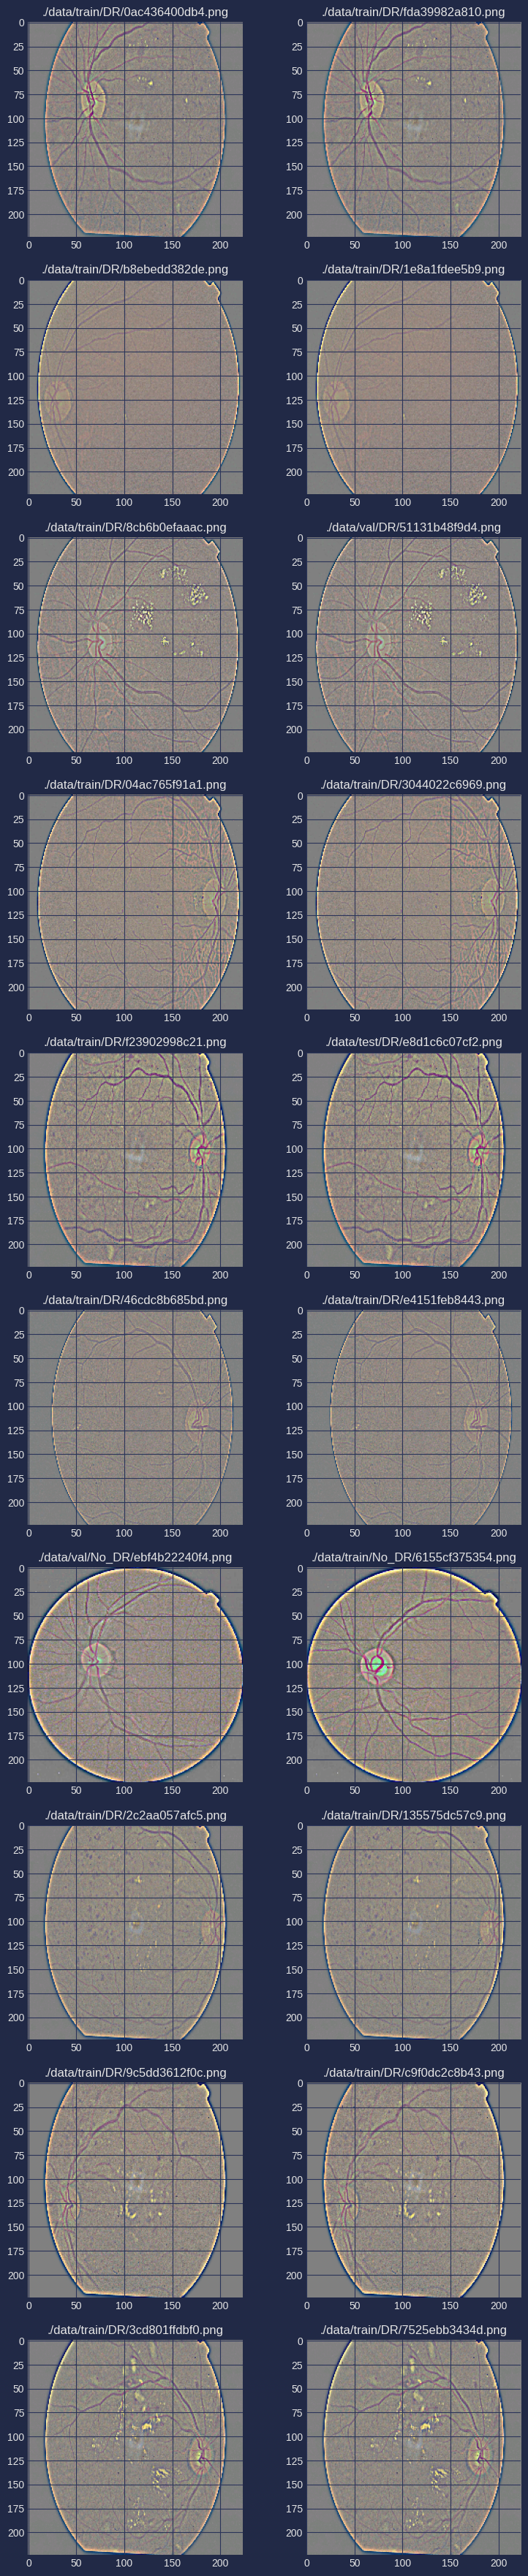

In [ ]:
num_to_show = 10
figure = plt.figure(figsize = (9, 45))

for i, im_hash in enumerate(random.sample([*dup_dict2.keys()], num_to_show)):
    images = list(dup_dict2[im_hash])
    im1 = np.asarray(Image.open(f'{images[0]}'))
    im2 = np.asarray(Image.open(f'{images[1]}'))
    plt.subplot(num_to_show, 2, 2*i + 1)
    plt.title(f'{images[0]}')
    plt.imshow(im1)
    plt.subplot(num_to_show, 2, 2*i + 2)
    plt.title(f'{images[1]}')
    plt.imshow(im2)

In [ ]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/train', target_size=(224, 224), shuffle = True)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/test', target_size=(224, 224), shuffle = True)
val_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/val', target_size=(224, 224), shuffle = True)

Found 2196 images belonging to 2 classes.
Found 916 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


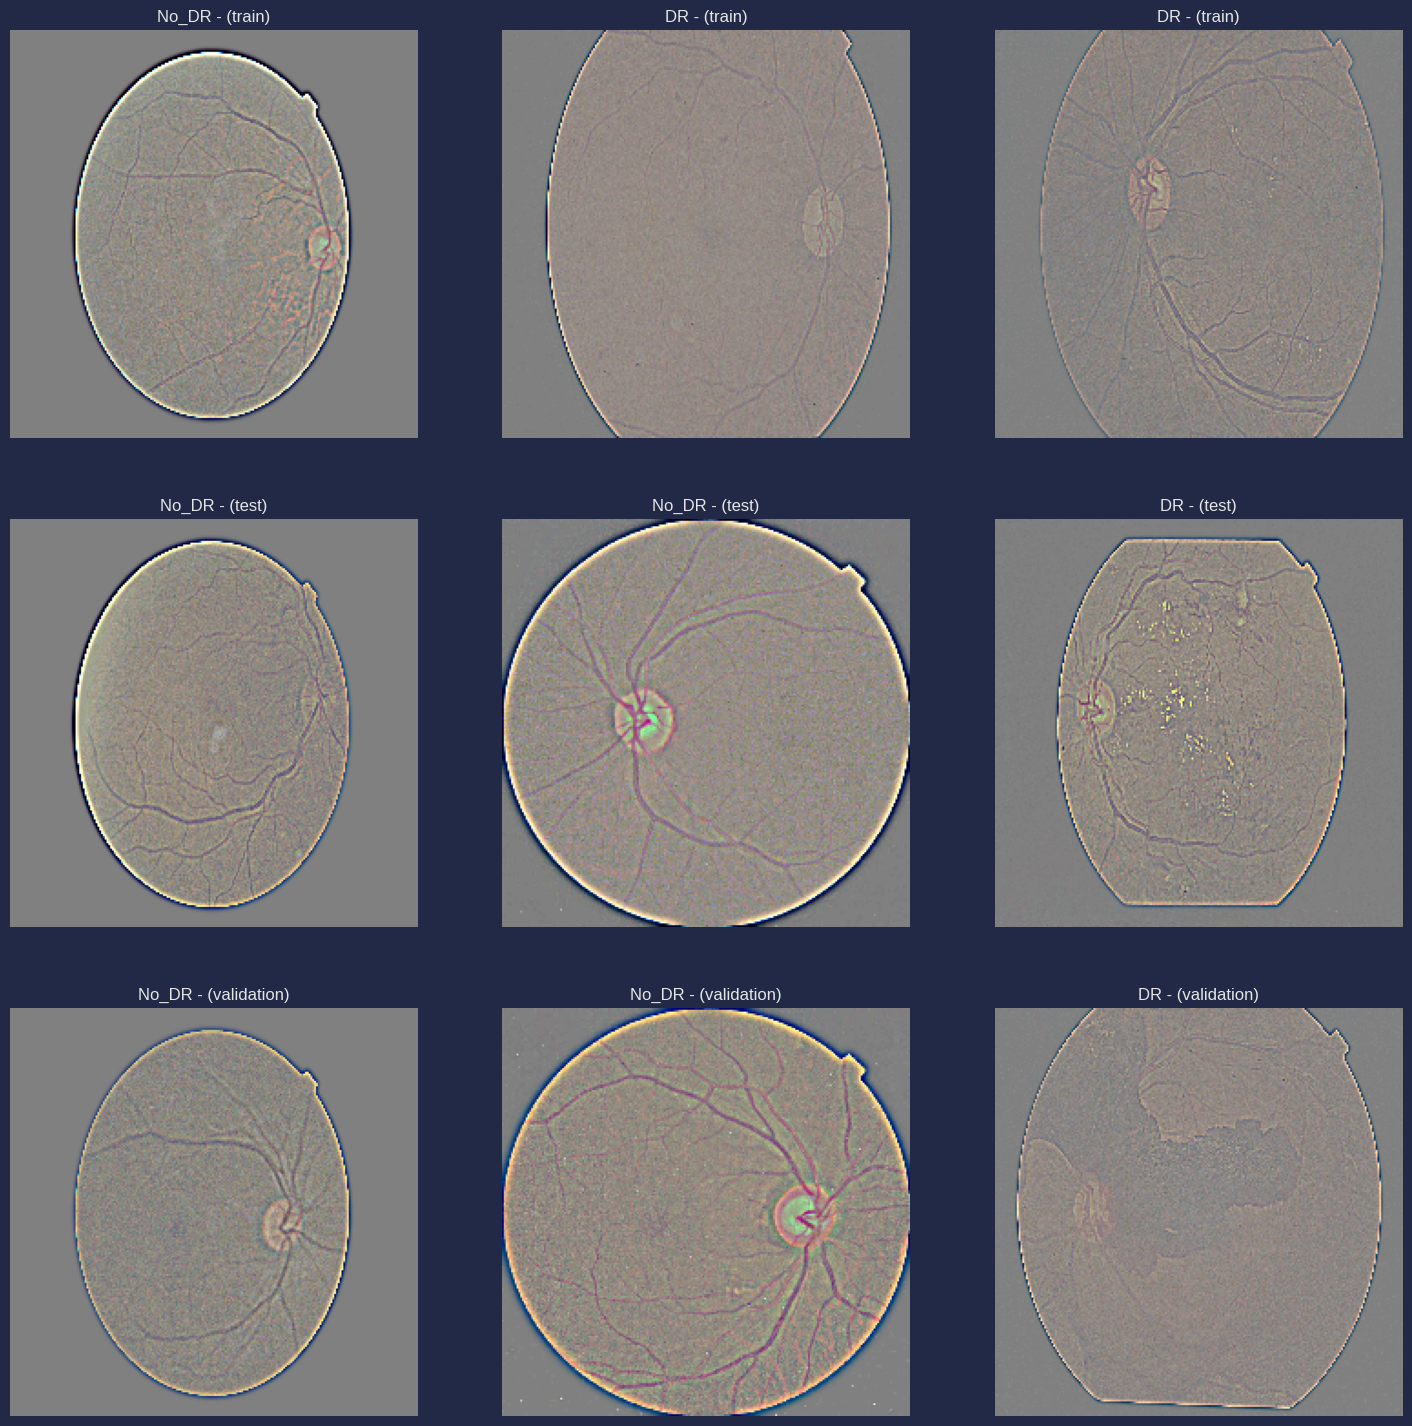

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18), sharey='col')

for i, name, data_gen in [*zip(range(3), ['train', 'test', 'validation'], [train_data, test_data, val_data])]:
    for j in range(3):
        n_batch, n_image = np.random.randint(32), np.random.randint(data_gen.n//32)
        ax[i][j].imshow(
            train_data[n_image][0][n_batch]
        )
        label = np.argmax(train_data[n_image][1][n_batch])
        ax[i][j].set_title(f'{["DR", "No_DR"][label]} - ({name})')
        ax[i][j].axis('off')

In [ ]:

############## NORMAL MACHINE LEARNING CODE #####################################


'''
# Assuming you have a dataset with features (X) and labels (y)

# Create a feature extraction and dimensionality reduction pipeline
feature_extraction = StandardScaler()  # Normalize the features
dimensionality_reduction = PCA(n_components=100)  # Reduce dimensionality to 100 components

# Create a RandomForestClassifier for classification
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline that combines feature extraction, dimensionality reduction, and classification
pipeline = Pipeline([
    ('feature_extraction', feature_extraction),
    ('dimensionality_reduction', dimensionality_reduction),
    ('classifier', classifier)
])

# Train the model
pipeline.fit(X, y)

# Make predictions
y_pred = pipeline.predict(X)

# Evaluate the model using appropriate metrics
# You may need to split your data into training and testing sets for proper evaluation
'''


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape=train_data.image_shape
)
base_model.trainable = False

input = tf.keras.layers.Input(shape = train_data.image_shape)
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
dense0 = tf.keras.layers.Dense(100, activation = 'relu')
dense1 = tf.keras.layers.Dense(50, activation = 'relu')
predict = tf.keras.layers.Dense(2, activation = 'sigmoid')

x = preprocess(input)
x = base_model(x)
x = global_average_pooling(x)
x = dense0(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = dense1(x)

model = tf.keras.Model(input, predict(x))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
primary_learning_rate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=primary_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()]
              )

In [ ]:
model.evaluate(test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 16s 194ms/step - loss: 0.7675 - accuracy: 0.5066 - precision: 0.5066 - recall: 0.5066


[0.7675095200538635,
 0.5065501928329468,
 0.5065501928329468,
 0.5065501928329468]

In [ ]:
history = model.fit(train_data, epochs=30, validation_data=val_data)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 [==============================] - 22s 244ms/step - loss: 0.7115 - accuracy: 0.5287 - precision: 0.5202 - recall: 0.5328 - val_loss: 0.6895 - val_accuracy: 0.4927 - val_precision: 0.4927 - val_recall: 0.4927
Epoch 2/30
69/69 [==============================] - 16s 231ms/step - loss: 0.6961 - accuracy: 0.5287 - precision: 0.5146 - recall: 0.5387 - val_loss: 0.6880 - val_accuracy: 0.4927 - val_precision: 0.4927 - val_recall: 0.4927
Epoch 3/30
69/69 [==============================] - 11s 165ms/step - loss: 0.6934 - accuracy: 0.5346 - precision: 0.5316 - recall: 0.5328 - val_loss: 0.6817 - val_accuracy: 0.8818 - val_precision: 0.6051 - val_recall: 0.9891
Epoch 4/30
69/69 [==============================] - 15s 218ms/step - loss: 0.6848 - accuracy: 0.5774 - precision: 0.5519 - recall: 0.5323 - val_loss: 0.6759 - val_accuracy: 0.5364 - val_precision: 0.5398 - val_recall: 0.5545
Epoch 5/30
69/69 [==============================] - 15s 213ms/step - loss: 0.6763 - accuracy: 0.5988 - precisio

In [ ]:
loss, accuracy, _, _ = model.evaluate(test_data)
report_dict['freezed-mobilenet-based-model'] = [loss, accuracy]

29/29 [==============================] - 7s 249ms/step - loss: 0.3483 - accuracy: 0.8504 - precision: 0.8495 - recall: 0.8504


In [ ]:
print('Test Results\n')
loss_val = report_dict[model_name][0]
accu_val = report_dict[model_name][1]
print(f'{model_name:50s}| loss: {loss_val:8.3f} | accuracy: {accu_val:.2%}')

Test Results

freezed-mobilenet-based-model                     | loss:    0.348 | accuracy: 85.04%
